# **Mini project II :**    Interpolation with Radial Basis Function Neural Network (RBFNN)

**Student Name**: **Amirali Khatib**

**Student ID**: **9722743149**

**Professor Name**: **Dr. Mohammadreza-R Akbarza deh-T**

# **Preface**

Regarding the title of the project, we aim to implement Radial Basis Function Neural Network (RBFNN) in order to recognize the mathematical behaviour of $sin(\frac{x}{2})$ and $tan(\frac{x}{2})$. We should follow the steps below in order to develope this type of Neural Network and deploy it.

* Simulate $sin(\frac{x}{2})$ output by randomly given $x$.
* Split the Simulated data into **Estimation set**, **Validation set** and **Test set**.
* Build RBFNN's structure and machanism  by defining functions
* Train bulit RBFNN on estimation set and evaluate (monitoring cost function during each epoch) its perfomance with Validation set. (This step are excecuted on different hyperparameters' adjustment to see which combination of hyperparamters give us a better result)
* Predict the value of Test set and make a comparison between **predicted** and **actual** value by **RMSE** metric.
* Choose the best model and train it on whole **training set** (`Val_set + Est_set`)

# **Import required libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Problem 1: Deploy RBFNN on $sin(\frac{x}{2})$**

## **Constructing the dataset**


In [2]:
x = np.arange(0,4*np.pi, 10**(-3))
y = [np.sin(t/2) for t in x]
data = {'x': x,
        'y': y}

data['noisy'] = [(data['y'][i] + .0125 * float(np.random.normal(size = 1))) for i in range(len(x))]

data = pd.DataFrame(data)
len(data)

12567

### **Visualizing the dataset**

#### **Data without noise**

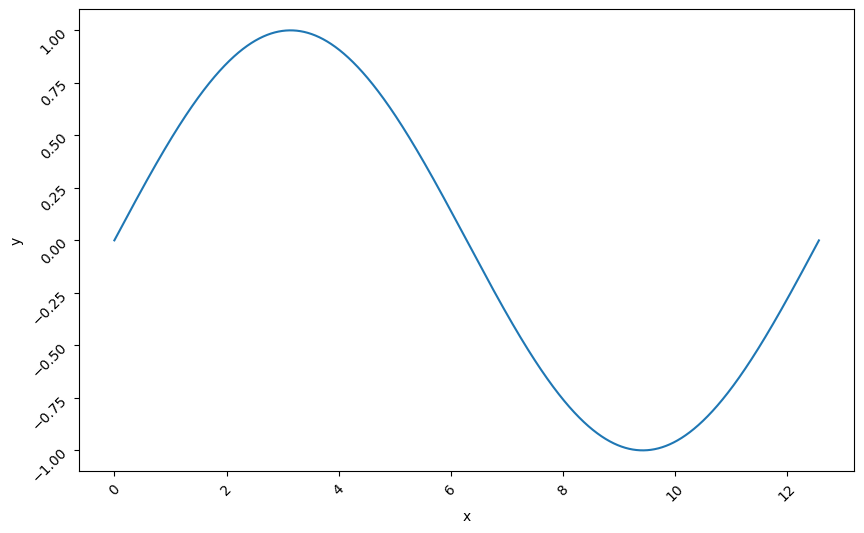

In [3]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(x = 'x', y = 'y', data = data)
ax.tick_params(rotation=45)
plt.show()

#### **Noisy data**

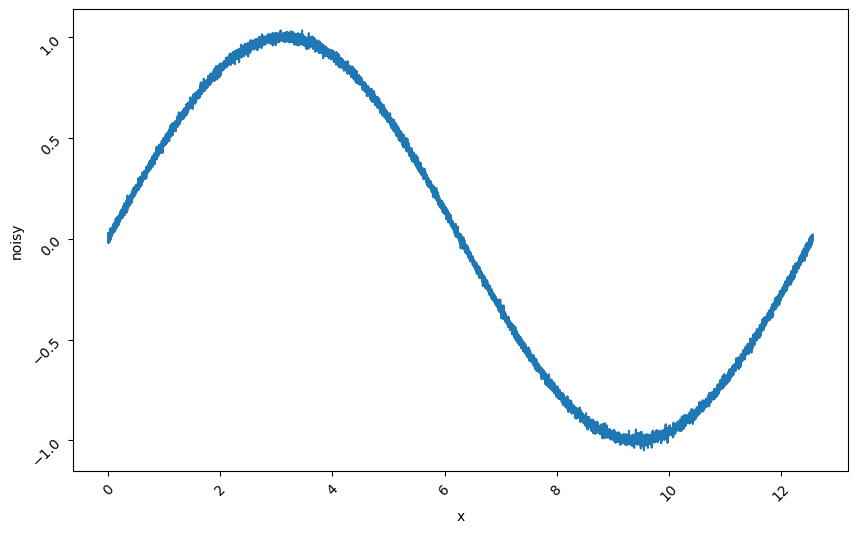

In [4]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(x = 'x', y = 'noisy', data = data)
ax.tick_params(rotation=45)
plt.show()

In [5]:
data.head(5)

,x,y,noisy
0,0.000,0.0000,-0.000421
1,0.001,0.0005,-0.020384
2,0.002,0.0010,-0.004813
3,0.003,0.0015,0.011264
4,0.004,0.0020,0.006993


### **Shuffling the dataset**

In [6]:
data = data.sample(frac = 1)

### **Splitting the dataset**
We define a function that can split the dataset like the figure below:


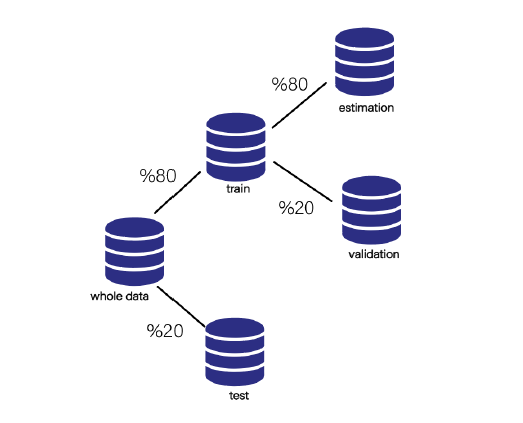

In [7]:
def split_80_20(data, ratio = .2):
    indx = int(len(data) * ratio)
    d20, d80 = data.iloc[:indx], data.iloc[indx:]
    return d20, d80

In [8]:
tst_set , trn_set = split_80_20(data)
est_set , val_set = split_80_20(trn_set)

## **Developing the RBFNN**

In this step we should define many functions and put them together so as to develope RBFNN. The steps below should be taken to make this phase done:
* **Centriod Initialization**
* **Beta Initialization**
* **Weight & Bias Initialization**
* **Define the Activation function (Radial Basis function)**
* **Define the Forward propagation functions**
* **Define evaluation-based functions such as Cost Function and RMSE**
* **Define the Back propagation functions (gradient and update)**
* **Put these fuctions above together and define the fitting function**
* **Use forward propation functions to define prediction function**

The figure below show the structure of RBFNN (10 neurons in hidden layer)

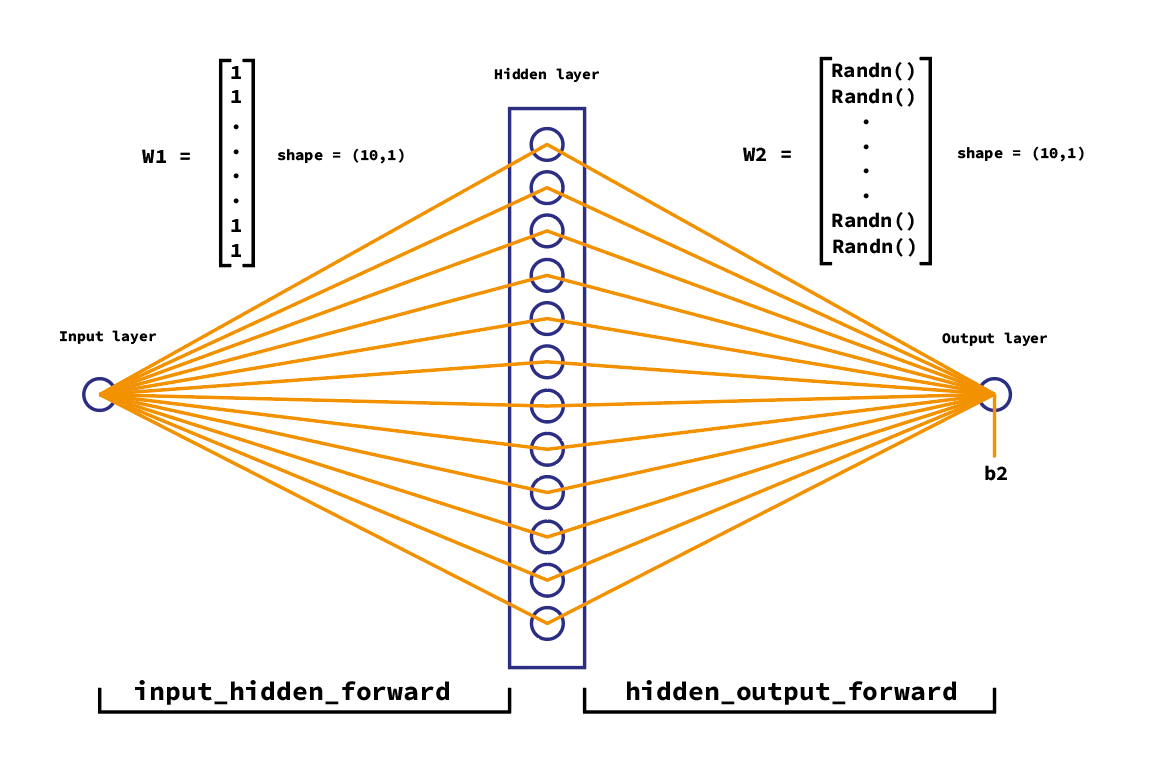

### **Centroid Initialization**

**what is centroid in RBFNN?**

Centroid is one of the parameters of Radial Basis Function. centroids can be define in 2 ways. Both of them are mentioned below:
* **Define centroids through taking the average of each final clusters in clustering approach using K-means algorithms. (Number of clusters must be the same as the number of hidden_layer's neurons.)**
* **Randomly choose N sample from our dataset to initialize N centroid's value then update their values using gradien descent algorithm in each epoch of training procedure.** 


In [9]:
def centroid_initializer(data,n_hidden_layer):
    return np.random.choice(data.x, size = n_hidden_layer, replace=False, p = None)

### **Beta Initialization**



**What is Beta in RBFNN?**

In a Radial Basis Function Neural Network (RBFNN), beta (β) refers to a parameter that determines the spread or width of the radial basis functions. Each radial basis function is associated with a specific centroid, and the value of β controls how quickly the function decays as the distance from the centroid increases. beta can be define in two ways. Both of them are mentioned below:
* **Taking the standard deviation of each final clusters in Kmeans algorithms**
* **Using the heuristic method in a way that we take the median of absolute of distance between specific hidden layer neuron's centroid and the others.**


In [10]:
# Median distance function
def median_distance(x, arr):
    euc_dist_list = []
    # Creating distance list
    for p in arr:
        d = np.abs(x-p)
        if d == 0:
            pass
        else:
            euc_dist_list.append(d)
            pass
    # Calculating median among distance values
    return np.median(euc_dist_list)

# Beta Initializer
def beta_initalizer(centroids):
    return np.array([median_distance(c, centroids) for c in centroids])

### **Genral Initializer**

We call `centroid_initializer` and `beta_initalizer` in the `param_initializer`. Moreover, we initialize weights and bias values in it.

In [11]:
def param_initializer(n_input_layer, n_hidden_layer, n_output_layer):
    param = {}
    param['w1'] = np.ones(n_hidden_layer).reshape(-1,1)
    param['w2'] = np.random.randn(n_hidden_layer).reshape(-1,1)
    param['b2'] = np.random.randn(n_output_layer).reshape(-1,1)
    c = centroid_initializer(data,n_hidden_layer)
    param['c'] = c.reshape(-1,1)
    beta = beta_initalizer(c)
    param['beta'] = beta.reshape(-1,1)
    return param

### **Activation Function (Gaussian function)**
Gussian function (One of the common types of Radial Basis functions) that we use it as an activation function is defined below:

$ \varphi(x ,c, \beta )= exp(-\beta\|x -c \|^{2})$

$ \beta = \frac{1}{\sigma ^ {2}}$ 

In [12]:
def phi(x,c,beta): return np.exp(-beta * (np.abs(x - c)**2))

### **Evaluation-based functions**

#### **Cost Function**

The cost function formula is defined below:

$ J(w_{2i}, b_{2}, \beta_{i}, c_{i}) = \frac {1}{2m}\sum_{j = 1}^{m}(\sum_{i=1}^{n} w_{2i}\varphi(x_{j} ,c_{i}, \beta_{i} ) - y_{i}) ^ {2} $

$ \varphi(x_{j} ,c_{i}, \beta_{i} )= exp(-\beta_{i}\|x_{j} -c_{i} \|^{2})$

$ n = $ number of hidden layer neurons 

$ m = $ number of training data

In [13]:
def cost_function(data, param):
    m = len(data)
    J = 0
    for i in range(len(data)):
        H = input_hidden_forward(data.iloc[i][0], param['w1'], param['c'], param['beta'])
        O = hidden_output_forward(H, param['w2'], param['b2'])
        J += (O - data.iloc[i][2]) ** 2
    return (1/(2*m)) * J

#### **RMSE**

The Root mean square error is defined below:

$ RMSE = \sqrt{\frac{\sum_{j=1}^{m}(y_{j} - \hat y_{j})}{N}}$

In [14]:
def rmse(y, y_hat): return np.sqrt((1/len(y_hat)) * np.sum((y - y_hat)**2))

### **Forward propagation functions**

#### **Input to Hidden**

In [15]:
def input_hidden_forward(x,w1,c,beta): return phi(x * w1, c, beta)

#### **Hidden to Output**

In [16]:
def hidden_output_forward(A, w2, b2): return b2 + np.dot(w2.T, A)

### **Back propagation functions**
Gradients of $J$ are known as partial derivatives of J. These gradients are calculate below:


$ \frac {\partial J}{\partial w_{2i}} = \frac {1}{m} \sum_{j=1}^{m}[(b_{2} + \sum_{i=1}^{N}w_{2i}(exp(-\beta_{i}(x_{j}-c_{i})^{2}))-y_{j})(exp(-\beta_{i}(x_{j}-c_{i})^{2}))]$

$ \frac {\partial J}{\partial b_{2}} = \frac {1}{m} \sum_{j=1}^{m}[(b_{2} + \sum_{i=1}^{N}w_{2i}(exp(-\beta_{i}(x_{j}-c_{i})^{2}))-y_{j})(1)] $

$ \frac {\partial J}{\partial \beta_{i}} = \frac {1}{m} \sum_{j=1}^{m}[(b_{2} + \sum_{i=1}^{N}w_{2i}(exp(-\beta_{i}(x_{j}-c_{i})^{2}))-y_{j})(w_{2i}(x_{j} - c_{i})^{2}exp(-\beta_{i}(x_{j}-c_{i})^{2}))]$

$ \frac {\partial J}{\partial c_{i}} = \frac {1}{m} \sum_{j=1}^{m}[(b_{2} + \sum_{i=1}^{N}w_{2i}(exp(-\beta_{i}(x_{j}-c_{i})^{2}))-y_{j})(w_{2i}(2\beta_{i}(x_{j}-c_{i}))exp(-\beta_{i}(x_{j}-c_{i})^{2}))]$


#### **Gradient Function**

In [17]:
def grads (data, param):
    m = len(data)
    # ========dw2i=========
    dw2i = 0
    for i in range(len(data)):
        Dw2i = param['b2'] + np.dot(param['w2'].T, phi(data.iloc[i][0] * param['w1'], param['c'], param['beta'])) - data.iloc[i][2]
        Dw2i = Dw2i * phi(data.iloc[i][0] * param['w1'], param['c'], param['beta'])
        dw2i += Dw2i
    dw2i = (1/m) * dw2i
  
    #=========db2==========
    db2 = 0
    for i in range(len(data)):
        Db2 = param['b2'] + np.dot(param['w2'].T, phi(data.iloc[i][0] * param['w1'], param['c'], param['beta'])) - data.iloc[i][2]
        Db2 = Db2 * 1
        db2 += Db2
    db2 = (1/m) * db2

    #========dbetai========
    dbetai = 0
    for i in range(len(data)):
        Dbetai = param['b2'] + np.dot(param['w2'].T, phi(data.iloc[i][0] * param['w1'], param['c'], param['beta'])) - data.iloc[i][2]
        Dbetai = Dbetai * (-1) * (param['w2'] * ((data.iloc[i][0] - param['c'])**2))
        Dbetai = Dbetai * phi(data.iloc[i][0] * param['w1'], param['c'], param['beta'])
        dbetai += Dbetai
    dbetai = (1/m) * dbetai

    #========dci============
    dci = 0
    for i in range(len(data)):
        Dci = param['b2'] + np.dot(param['w2'].T, phi(data.iloc[i][0] * param['w1'], param['c'], param['beta'])) - data.iloc[i][2]
        Dci = Dci * (2 * param['w2'] * param['beta'] * (data.iloc[i][0] - param['c']))
        Dci = Dci * phi(data.iloc[i][0] * param['w1'], param['c'], param['beta'])
        dci += Dci
    dci  = (1/m) * dci

    grad = {}
    grad['dw2i'], grad['db2'], grad['dbetai'], grad['dci'] = dw2i, db2, dbetai, dci
    return grad

#### **Update parameters using their gradients**

We implement gradient descent algotithm in order to update parameters in each epoch. Our purpose is to decrease $J$ in each iteration (epoch).



Repeat{

$w_{2i} := w_{2i} - \eta \frac {\partial J}{\partial w_{2i}}$

$b_{2} := b_{2} - \eta \frac {\partial J}{\partial b_{2}}$

$\beta_{i} := \beta_{i} -\eta \frac{\partial J}{\partial beta_{i}}$

$c_{i} := c_{i} - \eta \frac {\partial J}{\partial c_{i}}$

}

In [18]:
def update_param(param, grad, learning_rate):
    param['w2']   -= learning_rate * grad['dw2i']
    param['b2']   -= learning_rate * grad['db2']
    param['beta'] -= learning_rate * grad['dbetai']
    param['c']    -= learning_rate * grad['dci']
    return param

### **RBFNN fitting function**
We put all the functions above together so as to build RBFNN fitting functions. you can see the main functions that are called in the RBFNN fitting function.

In [20]:
def RBFNN_fit(data, n_input_layer, n_hidden_layer, n_output_layer, epoch, learning_rate):
    # Data splitting
    tst_set , trn_set = split_80_20(data)
    val_set, est_set= split_80_20(trn_set)
    # Initialize parameters
    param = param_initializer(n_input_layer, n_hidden_layer, n_output_layer)
    
    # Training
    J_list_est = []
    J_list_val = []
    
    for i in range(1,epoch+1):
        
        # print current epoch
        if i % 10 == 0: print(f'epoch{i} ... :)')
        else: pass
        # Calculate partial derivatives as gradients
        gradient = grads(est_set, param)
        # update paramters
        param = update_param(param, gradient, learning_rate)
        # add cost function of current to a list
        J_list_est.append(float(cost_function(est_set, param)))
        J_list_val.append(float(cost_function(val_set, param)))
    
    # Plot cost function trend during the epochs
    df = pd.DataFrame({'Epoch': [t for t in range(1,epoch+1)],
                        'Estimaion': J_list_est,
                        'Validation': J_list_val})

    df = pd.melt(df, id_vars=['Epoch'], 
                  value_vars=['Estimaion','Validation'], 
                  var_name='data type',
                  value_name='cost function')

    plt.figure(figsize=(6,3))
    ax = sns.lineplot(x = 'Epoch', y = 'cost function', hue = 'data type', data = df)
    plt.show()

    return param, tst_set

### **RBFNN prediction function**
This functions take the updated parameters and test set as an inputs to predict the $\hat y$ and compare it with $y$ via line chart.  

In [21]:
def RBFNN_predict(data, param):
    y_hat_list = []
    for i in range(len(data)):
        # 0 --> 1
        A = input_hidden_forward(data.iloc[i][0],param['w1'],param['c'],param['beta'])
        # 1 --> 2
        y_hat = hidden_output_forward(A, param['w2'], param['b2'])
        y_hat_list.append(float(y_hat))

    # Plot predicted and actual value of 'y'
    report = pd.DataFrame({'x': data['x'],
                           'y': data['noisy'],
                           'y_hat':y_hat_list})
    report = pd.melt(report, id_vars=['x'], value_vars=['y', 'y_hat'], var_name='y & y_hat')
    plt.figure(figsize=(6,3))
    ax = sns.lineplot(data = report, x = 'x', y = 'value', hue = 'y & y_hat')  
    plt.show()

    return y_hat_list

### **Generlized RBFNN function**
This function performe training and prediction in itself.

In [22]:
def RBFNN(data, n_input_layer, n_hidden_layer, n_output_layer, epoch, learning_rate):
    # Training phase - Visualize the model performance on validation set
    param, tst_set = RBFNN_fit(data, n_input_layer, n_hidden_layer, n_output_layer, epoch, learning_rate)
    # Prediction Phase - Visualize the prediction and actual value
    y_hat_array = RBFNN_predict(tst_set, param)
    RMSE = rmse(y = tst_set['noisy'], y_hat = y_hat_array)
    return RMSE

## **Hyperparmeter tuning**
In this phase of the project we do some hyperparameter adjustments. You can see the related plots and analyse the models' perfomance. we should train 8 models with the combination these hyperparameters:

* Learning rate ($\eta$) = {0.3, 0.5}
* Number of hidden layer's neurons = {30, 40}
* Epoch = {30, 60}

RBFNN => n_hidden layer : 30 - learning rate : 0.3 - epoch : 30
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)


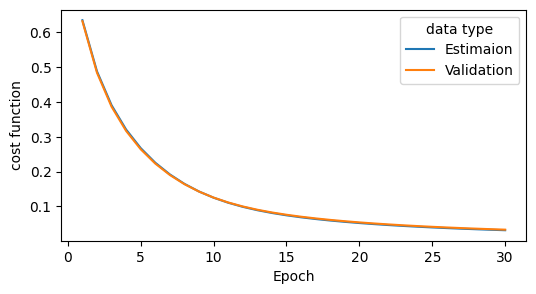

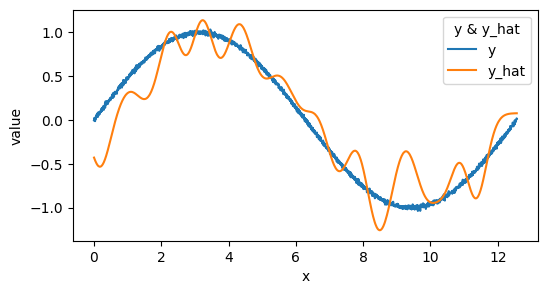

RBFNN => n_hidden layer : 30 - learning rate : 0.3 - epoch : 60
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)
epoch40 ... :)
epoch50 ... :)
epoch60 ... :)


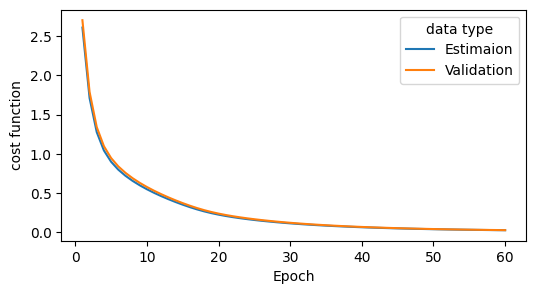

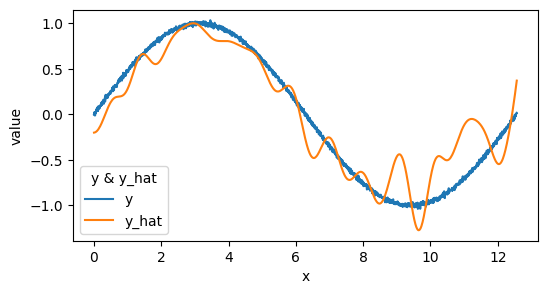

RBFNN => n_hidden layer : 30 - learning rate : 0.5 - epoch : 30
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)


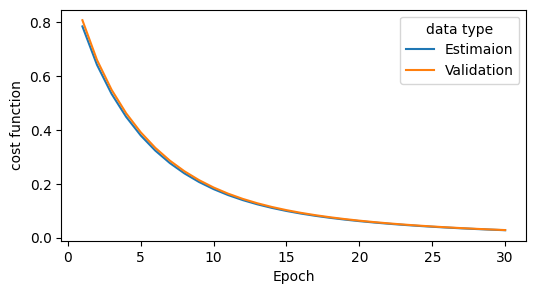

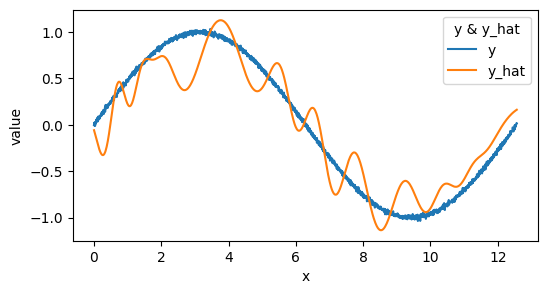

RBFNN => n_hidden layer : 30 - learning rate : 0.5 - epoch : 60
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)
epoch40 ... :)
epoch50 ... :)
epoch60 ... :)


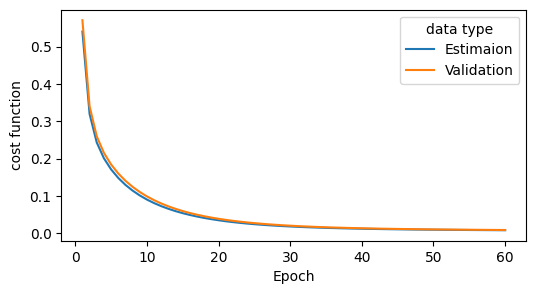

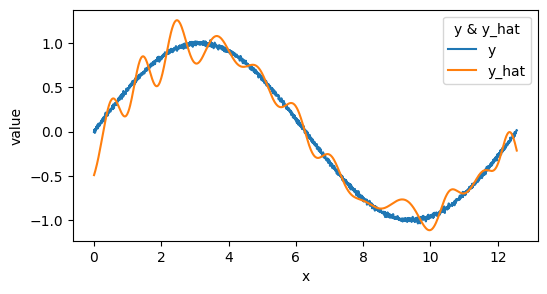

RBFNN => n_hidden layer : 40 - learning rate : 0.3 - epoch : 30
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)


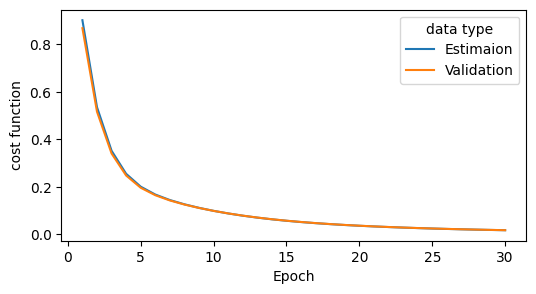

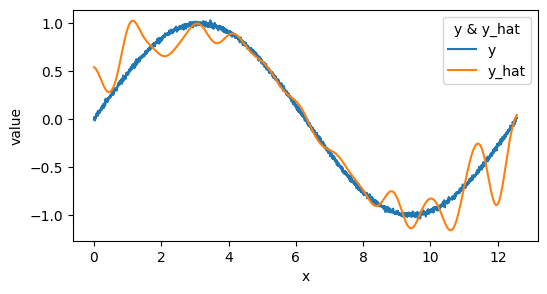

RBFNN => n_hidden layer : 40 - learning rate : 0.3 - epoch : 60
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)
epoch40 ... :)
epoch50 ... :)
epoch60 ... :)


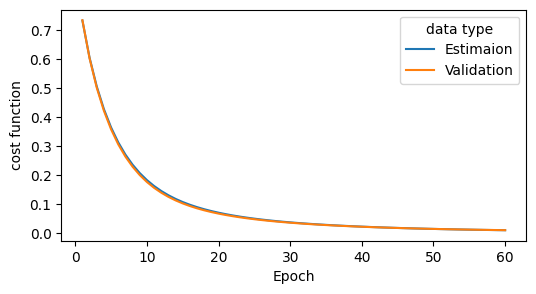

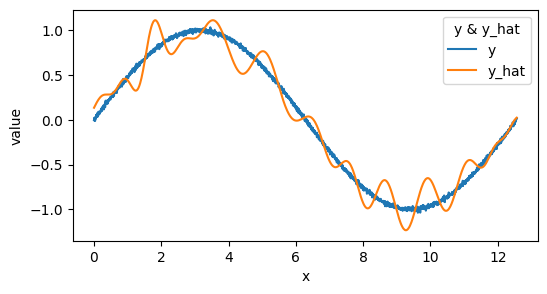

RBFNN => n_hidden layer : 40 - learning rate : 0.5 - epoch : 30
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)


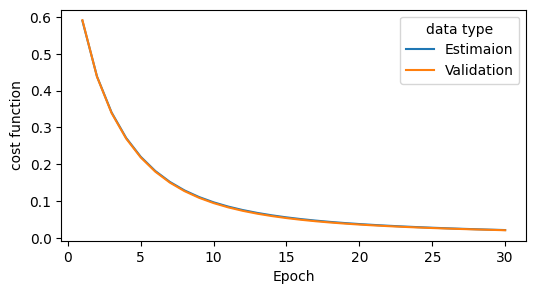

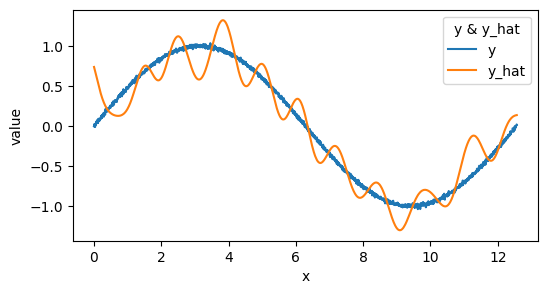

RBFNN => n_hidden layer : 40 - learning rate : 0.5 - epoch : 60
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)
epoch40 ... :)
epoch50 ... :)
epoch60 ... :)


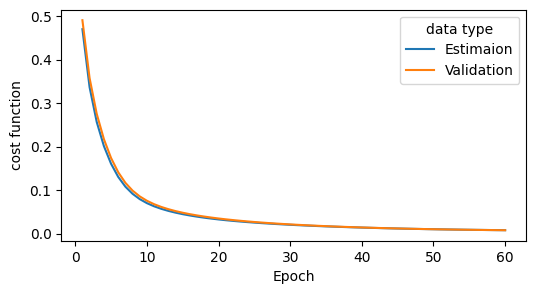

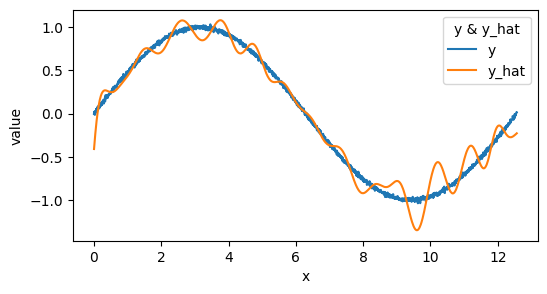

,n_hidden_layer,learning_rate,epoch,rmse
0,30,0.3,30,0.256737
1,30,0.3,60,0.229875
2,30,0.5,30,0.233007
3,30,0.5,60,0.135164
4,40,0.3,30,0.193036
5,40,0.3,60,0.142818
6,40,0.5,30,0.208170
7,40,0.5,60,0.122975


In [23]:
lr = [0.3, 0.5]
hidden = [30, 40]
epochs = [30, 60]
final_report = {'n_hidden_layer':[],
                'learning_rate':[],
                'epoch':[],
                'rmse':[]}
for h in hidden:
    for l in lr:
        for e in epochs:
            print('===================================================================')
            print(f'RBFNN => n_hidden layer : {h} - learning rate : {l} - epoch : {e}')
            final_report['n_hidden_layer'].append(h)
            final_report['learning_rate'].append(l)
            final_report['epoch'].append(e)
            RMSE = RBFNN(data = data,
                         n_input_layer = 1,
                         n_hidden_layer = h,
                         n_output_layer = 1,
                         epoch = e,
                         learning_rate = l)
            final_report['rmse'].append(RMSE)
pd.DataFrame(final_report)

According the **Models' RMSE table** we noticed that the **model 8** has the least RMSE value (**0.122975**).

# **Problem 2: Deploy RBFNN on $tan(\frac{x}{2})$**

## **Constructing the dataset**


In [24]:
x = np.arange(0,2*np.pi, 10**(-3))
y = [np.tan(t/2) for t in x]
data = {'x': x,
        'y': y}

data['noisy'] =  [(data['y'][i] + .02 * float(np.random.normal(size = 1))) for i in range(len(x))]

data = pd.DataFrame(data)
len(data)

6284

In [25]:
data.head()

,x,y,noisy
0,0.000,0.0000,0.015901
1,0.001,0.0005,-0.033053
2,0.002,0.0010,0.003874
3,0.003,0.0015,0.044748
4,0.004,0.0020,-0.058445


### **Visualizing the dataset**

#### **Data without noise**

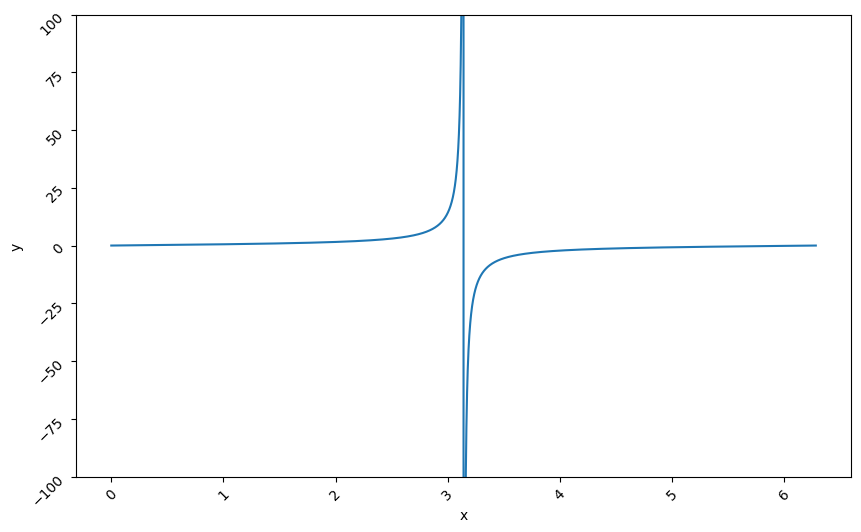

In [26]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(x = 'x', y = 'y', data = data)
ax.set(ylim = (-100, 100))
ax.tick_params(rotation=45)
plt.show()

#### **Noisy data**

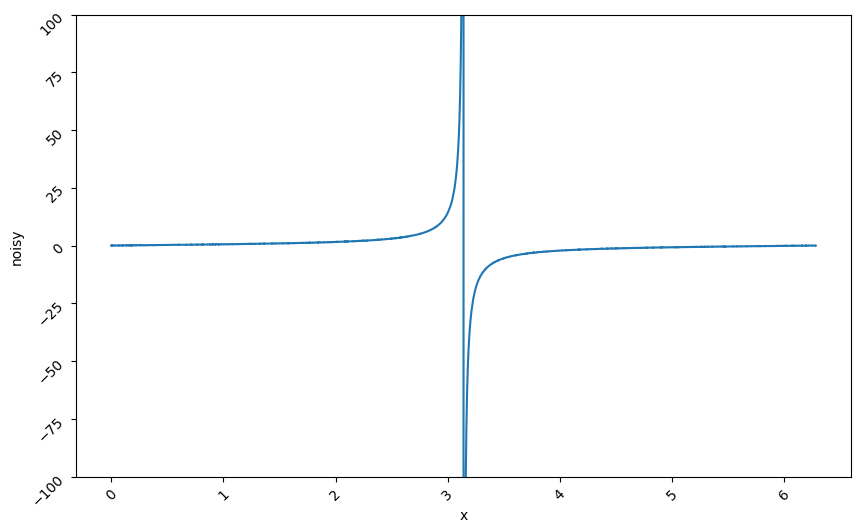

In [27]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(x = 'x', y = 'noisy', data = data)
ax.set(ylim=(-100, 100))
ax.tick_params(rotation=45)
plt.show()

### **Shuffling the dataset**

In [28]:
data = data.sample(frac = 1)
data.head()

,x,y,noisy
4044,4.044,-2.063811,-2.096150
734,0.734,0.384416,0.374779
3492,3.492,-5.649122,-5.647516
1377,1.377,0.822817,0.840411
3982,3.982,-2.238053,-2.243460


## **Hyperparmeter tuning**

In this phase of the project we do some hyperparameter adjustments. You can see the related plots and analyse the models' perfomance. we should train 12 models with the combination these hyperparameters:

* Learning rate ($\eta$) = {0.01, 0.1}
* Number of hidden layer's neurons = {30, 40}
* Epoch = {30, 60}

RBFNN => n_hidden layer : 30 - learning rate : 0.01 - epoch : 30
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)


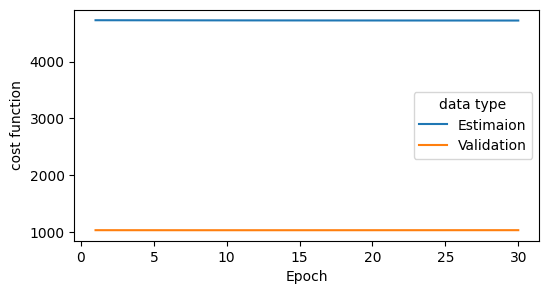

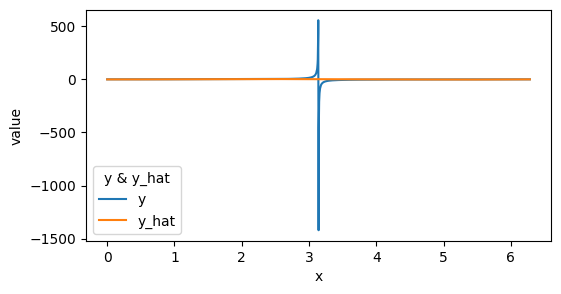

RBFNN => n_hidden layer : 30 - learning rate : 0.01 - epoch : 60
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)
epoch40 ... :)
epoch50 ... :)
epoch60 ... :)


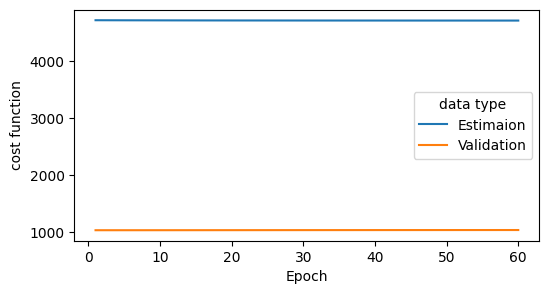

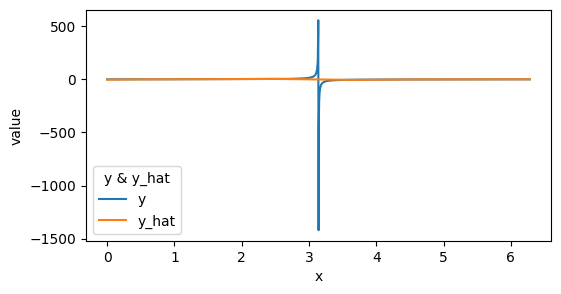

RBFNN => n_hidden layer : 30 - learning rate : 0.1 - epoch : 30
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)


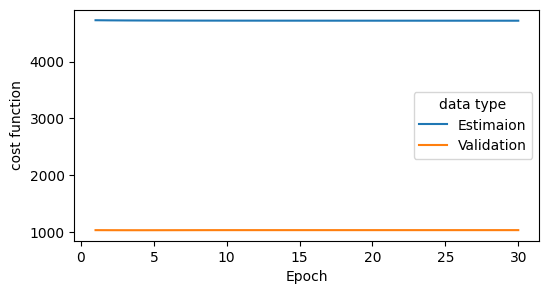

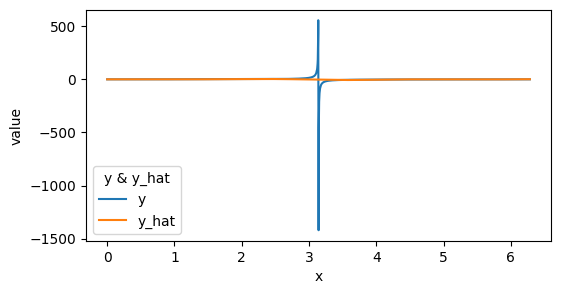

RBFNN => n_hidden layer : 30 - learning rate : 0.1 - epoch : 60
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)
epoch40 ... :)
epoch50 ... :)
epoch60 ... :)


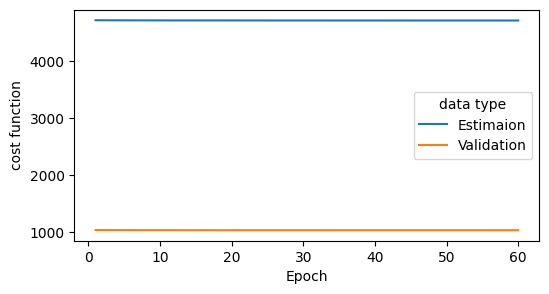

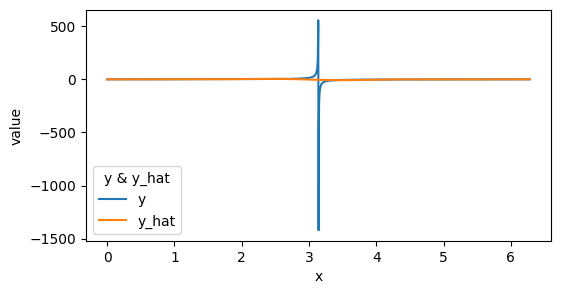

RBFNN => n_hidden layer : 40 - learning rate : 0.01 - epoch : 30
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)


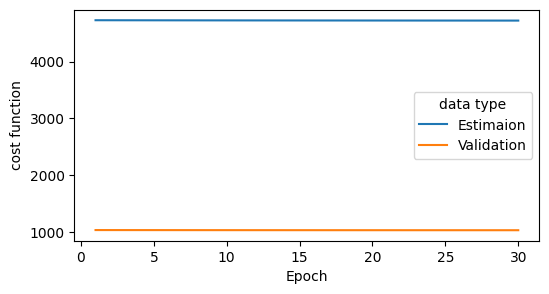

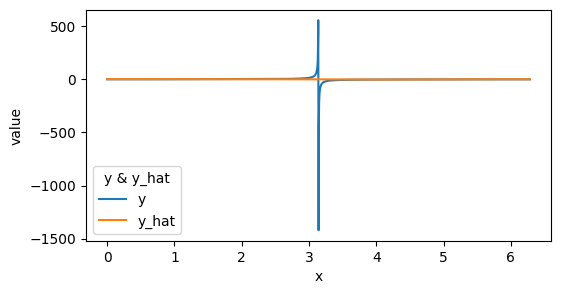

RBFNN => n_hidden layer : 40 - learning rate : 0.01 - epoch : 60
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)
epoch40 ... :)
epoch50 ... :)
epoch60 ... :)


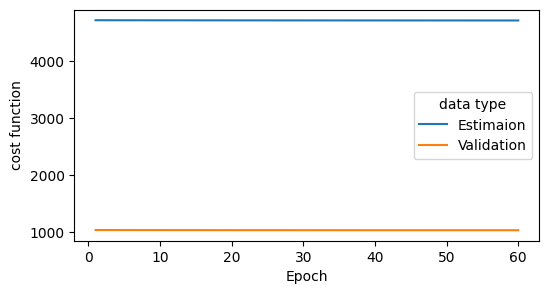

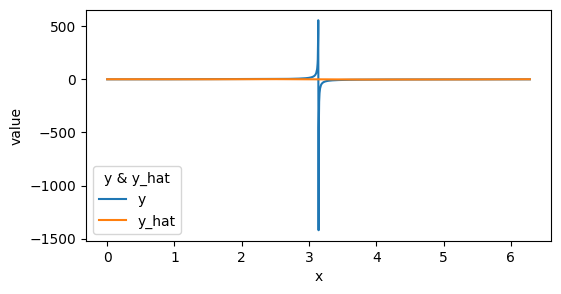

RBFNN => n_hidden layer : 40 - learning rate : 0.1 - epoch : 30
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)


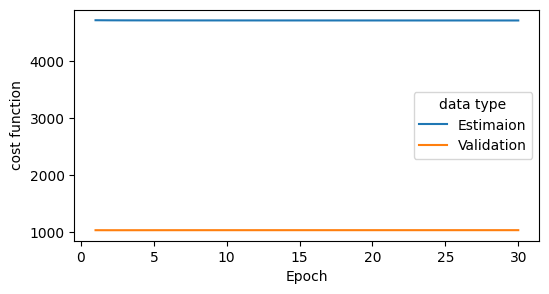

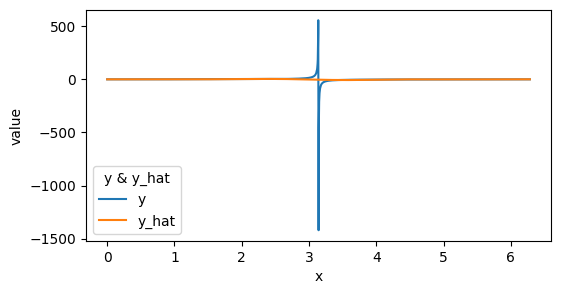

RBFNN => n_hidden layer : 40 - learning rate : 0.1 - epoch : 60
epoch10 ... :)
epoch20 ... :)
epoch30 ... :)
epoch40 ... :)
epoch50 ... :)
epoch60 ... :)


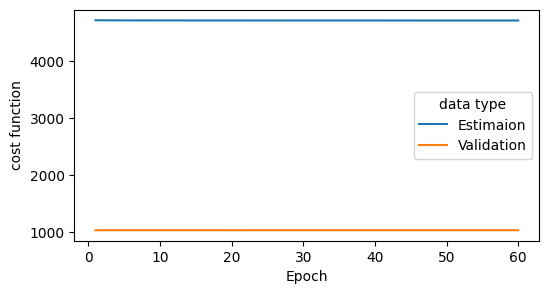

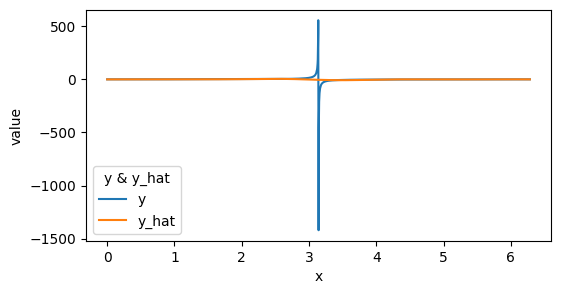

,n_hidden_layer,learning_rate,epoch,rmse
0,30,0.01,30,48.286613
1,30,0.01,60,48.234560
2,30,0.10,30,48.224896
3,30,0.10,60,48.202885
4,40,0.01,30,48.292293
5,40,0.01,60,48.265529
6,40,0.10,30,48.220780
7,40,0.10,60,48.204459


In [29]:
lr = [0.01,0.1]
hidden = [30, 40]
epochs = [30, 60]
final_report = {'n_hidden_layer':[],
                'learning_rate':[],
                'epoch':[],
                'rmse':[]}
for h in hidden:
    for l in lr:
        for e in epochs:
            print('===================================================================')
            print(f'RBFNN => n_hidden layer : {h} - learning rate : {l} - epoch : {e}')
            final_report['n_hidden_layer'].append(h)
            final_report['learning_rate'].append(l)
            final_report['epoch'].append(e)
            RMSE = RBFNN(data = data,
                         n_input_layer = 1,
                         n_hidden_layer = h,
                         n_output_layer = 1,
                         epoch = e,
                         learning_rate = l)
            final_report['rmse'].append(RMSE)
pd.DataFrame(final_report)

**Note**: While RBFNN with Gaussian functions in the hidden layer can be powerful in approximating certain functions, they may not perform well in predicting the $tan(\frac{x}{2})$ functionality, because The $tan(\frac{x}{2})$ function is highly non-linear, with abrupt changes and asymptotic behavior. RBFNNs with Gaussian functions are better suited for approximating smooth and continuous functions like $sin(\frac{x}{2})$. They may struggle to capture the rapid changes and asymptotes of $tan(\frac{x}{2})$ accurately.

# **Questions**

## **Q1**: How does a Radial Basis Function Neural Network work, and what are its advantages and disadvantages compared to other types of neural networks?

A Radial Basis Function Neural Network (RBFNN) is a type of artificial neural network that consists of three main layers: an input layer, a hidden layer with radial basis functions, and an output layer. Here's how it works:

* **Input layer:** The input layer receives the input data, which could be a vector of features or values.

* **Hidden layer:** The hidden layer contains radial basis functions (RBFs) as activation functions. Each RBF represents a prototype or center point in the input space. The activation of each RBF neuron is determined by the distance between the input pattern and its center point. Commonly used RBFs include Gaussian functions and Multiquadric functions.

* **Output layer:** The output layer combines the activations of the hidden layer neurons to produce the final output. Depending on the task, the output layer can have different configurations, such as a single neuron for regression or multiple neurons for classification.

The training process of an RBFNN involves two main steps:

* **Center initialization:** The centers of the RBF neurons are typically initialized using a clustering algorithm such as k-means. The clustering algorithm finds representative points in the input space to serve as the centers of the RBFs.

* **Weight adjustment:** The weights between the hidden and output layers are adjusted using a supervised learning algorithm, such as gradient descent or least squares. The goal is to minimize the difference between the predicted output and the desired output based on the training data.

Advantages of RBFNN compared to other types of neural networks:

* **Interpretable hidden layer:** RBFNNs have a transparent hidden layer that uses radial basis functions, which can be seen as prototypes or representatives of the input patterns. This allows for more intuitive interpretation and understanding of the network's behavior.

* **Non-linear approximation:** RBFNNs are capable of approximating complex non-linear functions, making them suitable for a wide range of problems.

* **Fast training:** Once the centers of the RBFs are initialized, the training process of an RBFNN is often fast and computationally efficient, especially compared to deep neural networks.

Disadvantages of RBFNN compared to other types of neural networks:

* **Choice of centers:** The selection and placement of the RBF centers are crucial for the network's performance. If the centers are not properly chosen, the RBFNN may struggle to accurately represent the underlying patterns in the data.

* **Number of hidden neurons:** Determining the appropriate number of hidden neurons in the RBFNN is a challenging task. Insufficient or excessive hidden neurons can lead to underfitting or overfitting, respectively.

* **Limited generalization:** RBFNNs may have difficulty generalizing well to unseen data, especially in high-dimensional input spaces. Without proper regularization techniques, they can be sensitive to noise in the training data.

Overall, RBFNNs have their strengths in terms of interpretability and non-linear approximation, but they also have limitations that need to be carefully addressed in order to achieve good performance. The choice of neural network architecture depends on the specific problem at hand and the characteristics of the dataset.

# **Q2:** 
## How can the hyperparameters of an RBFNN, such as the spread and number of neurons, be optimized for better performance?

Due to my computational capacity, I simplified the problem, I ran a for loop to train 8 models with  different combination of 3 types of hyperparameters (**number of neurons in hidden layer**, **epoch** and **learning rate**) on training set and evluated their performance by RMSE of their result in prediction of Validation set. There is also an other methods like Cross Validation.

**Note:** I did not consider spread ($\beta$) as a hyperparameter. Instead, I updated its value as a parameter during each epoch using gradient descent algorithm.

## **Q3:** 
## How can the performance of an RBFNN be evaluated and compared to other models, such as support vector machines or decision trees؟

To evaluate and compare the performance of an RBFNN with other models like Support Vector Machines (SVMs) or decision trees, you can employ various evaluation metrics and techniques. Here are some commonly used approaches:
* **Evaluation metrics:** Calculate accuracy (In classification problems), which measures the overall correctness of predictions, as a primary evaluation metric. **Accuracy** is the ratio of correct predictions to the total number of instances. Additionally, you can consider other metrics such as **precision**, **recall**, **F1-score**, or area under the Receiver Operating Characteristic (**ROC**) curve and Root mean square (**RMSE**), depending on the nature of your problem,  error (classification or regression).

* **Computational efficiency:** Consider the computational efficiency of the models, such as training time and prediction time. Some models, like decision trees, can be faster to train and evaluate compared to more complex models like RBFNN or SVMs. However, computational efficiency alone should not be the sole criterion for model selection, as accuracy and performance are typically more critical.